# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:47 - loss: 0.6951

  28/1875 [..............................] - ETA: 3s - loss: 0.5573   

  58/1875 [..............................] - ETA: 3s - loss: 0.4717

  83/1875 [>.............................] - ETA: 3s - loss: 0.4334

 114/1875 [>.............................] - ETA: 3s - loss: 0.4027

 150/1875 [=>............................] - ETA: 2s - loss: 0.3784

 187/1875 [=>............................] - ETA: 2s - loss: 0.3598

 224/1875 [==>...........................] - ETA: 2s - loss: 0.3453

 254/1875 [===>..........................] - ETA: 2s - loss: 0.3353

 284/1875 [===>..........................] - ETA: 2s - loss: 0.3266

 312/1875 [===>..........................] - ETA: 2s - loss: 0.3194

 342/1875 [====>.........................] - ETA: 2s - loss: 0.3125

 378/1875 [=====>........................] - ETA: 2s - loss: 0.3050

 412/1875 [=====>........................] - ETA: 2s - loss: 0.2986

 440/1875 [======>.......................] - ETA: 2s - loss: 0.2939

 471/1875 [======>.......................] - ETA: 2s - loss: 0.2890

 505/1875 [=======>......................] - ETA: 2s - loss: 0.2840

 530/1875 [=======>......................] - ETA: 2s - loss: 0.2806

 559/1875 [=======>......................] - ETA: 2s - loss: 0.2769

 580/1875 [========>.....................] - ETA: 2s - loss: 0.2743

 612/1875 [========>.....................] - ETA: 2s - loss: 0.2707

 639/1875 [=========>....................] - ETA: 2s - loss: 0.2677

 671/1875 [=========>....................] - ETA: 2s - loss: 0.2644

 707/1875 [==========>...................] - ETA: 1s - loss: 0.2609

 734/1875 [==========>...................] - ETA: 1s - loss: 0.2584

 758/1875 [===========>..................] - ETA: 1s - loss: 0.2563

 788/1875 [===========>..................] - ETA: 1s - loss: 0.2538

 818/1875 [============>.................] - ETA: 1s - loss: 0.2513

 848/1875 [============>.................] - ETA: 1s - loss: 0.2490

 878/1875 [=============>................] - ETA: 1s - loss: 0.2468

 915/1875 [=============>................] - ETA: 1s - loss: 0.2442

 950/1875 [==============>...............] - ETA: 1s - loss: 0.2418

 979/1875 [==============>...............] - ETA: 1s - loss: 0.2399

1013/1875 [===============>..............] - ETA: 1s - loss: 0.2378

1045/1875 [===============>..............] - ETA: 1s - loss: 0.2359

1076/1875 [================>.............] - ETA: 1s - loss: 0.2341

1109/1875 [================>.............] - ETA: 1s - loss: 0.2322

1145/1875 [=================>............] - ETA: 1s - loss: 0.2303

1174/1875 [=================>............] - ETA: 1s - loss: 0.2288

1205/1875 [==================>...........] - ETA: 1s - loss: 0.2273

1236/1875 [==================>...........] - ETA: 1s - loss: 0.2258

1268/1875 [===================>..........] - ETA: 0s - loss: 0.2242

1294/1875 [===================>..........] - ETA: 0s - loss: 0.2231

1320/1875 [====================>.........] - ETA: 0s - loss: 0.2219

1341/1875 [====================>.........] - ETA: 0s - loss: 0.2210

1373/1875 [====================>.........] - ETA: 0s - loss: 0.2196

1398/1875 [=====================>........] - ETA: 0s - loss: 0.2186

1426/1875 [=====================>........] - ETA: 0s - loss: 0.2174

1456/1875 [======================>.......] - ETA: 0s - loss: 0.2162

1485/1875 [======================>.......] - ETA: 0s - loss: 0.2151

1516/1875 [=======================>......] - ETA: 0s - loss: 0.2140

1546/1875 [=======================>......] - ETA: 0s - loss: 0.2129

1576/1875 [========================>.....] - ETA: 0s - loss: 0.2118

1606/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1637/1875 [=========================>....] - ETA: 0s - loss: 0.2097

1668/1875 [=========================>....] - ETA: 0s - loss: 0.2086

1698/1875 [==========================>...] - ETA: 0s - loss: 0.2077

1725/1875 [==========================>...] - ETA: 0s - loss: 0.2068

1755/1875 [===========================>..] - ETA: 0s - loss: 0.2059

1786/1875 [===========================>..] - ETA: 0s - loss: 0.2049

1815/1875 [============================>.] - ETA: 0s - loss: 0.2041

1846/1875 [============================>.] - ETA: 0s - loss: 0.2032

1875/1875 [==============================] - ETA: 0s - loss: 0.2023

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2023


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1022

  32/1875 [..............................] - ETA: 3s - loss: 0.1084

  63/1875 [>.............................] - ETA: 2s - loss: 0.1089

  87/1875 [>.............................] - ETA: 3s - loss: 0.1089

 108/1875 [>.............................] - ETA: 3s - loss: 0.1088

 129/1875 [=>............................] - ETA: 3s - loss: 0.1089

 158/1875 [=>............................] - ETA: 3s - loss: 0.1089

 187/1875 [=>............................] - ETA: 3s - loss: 0.1089

 215/1875 [==>...........................] - ETA: 3s - loss: 0.1089

 240/1875 [==>...........................] - ETA: 3s - loss: 0.1089

 263/1875 [===>..........................] - ETA: 3s - loss: 0.1089

 296/1875 [===>..........................] - ETA: 2s - loss: 0.1089

 327/1875 [====>.........................] - ETA: 2s - loss: 0.1088

 358/1875 [====>.........................] - ETA: 2s - loss: 0.1088

 389/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 414/1875 [=====>........................] - ETA: 2s - loss: 0.1087

 439/1875 [======>.......................] - ETA: 2s - loss: 0.1087

 462/1875 [======>.......................] - ETA: 2s - loss: 0.1086

 491/1875 [======>.......................] - ETA: 2s - loss: 0.1086

 515/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 540/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 566/1875 [========>.....................] - ETA: 2s - loss: 0.1084

 586/1875 [========>.....................] - ETA: 2s - loss: 0.1084

 612/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 643/1875 [=========>....................] - ETA: 2s - loss: 0.1083

 671/1875 [=========>....................] - ETA: 2s - loss: 0.1082

 700/1875 [==========>...................] - ETA: 2s - loss: 0.1081

 728/1875 [==========>...................] - ETA: 2s - loss: 0.1081

 744/1875 [==========>...................] - ETA: 2s - loss: 0.1080

 769/1875 [===========>..................] - ETA: 2s - loss: 0.1080

 791/1875 [===========>..................] - ETA: 2s - loss: 0.1079

 815/1875 [============>.................] - ETA: 2s - loss: 0.1079

 837/1875 [============>.................] - ETA: 2s - loss: 0.1079

 860/1875 [============>.................] - ETA: 1s - loss: 0.1078

 886/1875 [=============>................] - ETA: 1s - loss: 0.1078

 915/1875 [=============>................] - ETA: 1s - loss: 0.1077

 937/1875 [=============>................] - ETA: 1s - loss: 0.1077

 969/1875 [==============>...............] - ETA: 1s - loss: 0.1076

 990/1875 [==============>...............] - ETA: 1s - loss: 0.1075

1012/1875 [===============>..............] - ETA: 1s - loss: 0.1075

1028/1875 [===============>..............] - ETA: 1s - loss: 0.1075

1053/1875 [===============>..............] - ETA: 1s - loss: 0.1074

1083/1875 [================>.............] - ETA: 1s - loss: 0.1073

1110/1875 [================>.............] - ETA: 1s - loss: 0.1073

1142/1875 [=================>............] - ETA: 1s - loss: 0.1072

1173/1875 [=================>............] - ETA: 1s - loss: 0.1072

1204/1875 [==================>...........] - ETA: 1s - loss: 0.1071

1226/1875 [==================>...........] - ETA: 1s - loss: 0.1071

1254/1875 [===================>..........] - ETA: 1s - loss: 0.1070

1282/1875 [===================>..........] - ETA: 1s - loss: 0.1069

1312/1875 [===================>..........] - ETA: 1s - loss: 0.1069

1342/1875 [====================>.........] - ETA: 1s - loss: 0.1068

1372/1875 [====================>.........] - ETA: 0s - loss: 0.1068

1401/1875 [=====================>........] - ETA: 0s - loss: 0.1067

1430/1875 [=====================>........] - ETA: 0s - loss: 0.1067

1461/1875 [======================>.......] - ETA: 0s - loss: 0.1066

1490/1875 [======================>.......] - ETA: 0s - loss: 0.1066

1519/1875 [=======================>......] - ETA: 0s - loss: 0.1065

1541/1875 [=======================>......] - ETA: 0s - loss: 0.1065

1570/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1601/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1630/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1660/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1686/1875 [=========================>....] - ETA: 0s - loss: 0.1062

1712/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1738/1875 [==========================>...] - ETA: 0s - loss: 0.1061

1767/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1792/1875 [===========================>..] - ETA: 0s - loss: 0.1060

1814/1875 [============================>.] - ETA: 0s - loss: 0.1060

1840/1875 [============================>.] - ETA: 0s - loss: 0.1060

1870/1875 [============================>.] - ETA: 0s - loss: 0.1059

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1059


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1072

  30/1875 [..............................] - ETA: 3s - loss: 0.0996

  59/1875 [..............................] - ETA: 3s - loss: 0.0985

  88/1875 [>.............................] - ETA: 3s - loss: 0.0981

 117/1875 [>.............................] - ETA: 3s - loss: 0.0980

 146/1875 [=>............................] - ETA: 3s - loss: 0.0979

 175/1875 [=>............................] - ETA: 2s - loss: 0.0978

 204/1875 [==>...........................] - ETA: 2s - loss: 0.0978

 234/1875 [==>...........................] - ETA: 2s - loss: 0.0978

 257/1875 [===>..........................] - ETA: 2s - loss: 0.0978

 285/1875 [===>..........................] - ETA: 2s - loss: 0.0978

 309/1875 [===>..........................] - ETA: 2s - loss: 0.0979

 334/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 355/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 382/1875 [=====>........................] - ETA: 2s - loss: 0.0979

 412/1875 [=====>........................] - ETA: 2s - loss: 0.0979

 439/1875 [======>.......................] - ETA: 2s - loss: 0.0979

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0979

 488/1875 [======>.......................] - ETA: 2s - loss: 0.0979

 519/1875 [=======>......................] - ETA: 2s - loss: 0.0979

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0979

 581/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 611/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 640/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 670/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 695/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 721/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 745/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 769/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 795/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 822/1875 [============>.................] - ETA: 1s - loss: 0.0979

 851/1875 [============>.................] - ETA: 1s - loss: 0.0979

 879/1875 [=============>................] - ETA: 1s - loss: 0.0978

 909/1875 [=============>................] - ETA: 1s - loss: 0.0978

 939/1875 [==============>...............] - ETA: 1s - loss: 0.0978

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0978

 993/1875 [==============>...............] - ETA: 1s - loss: 0.0978

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1081/1875 [================>.............] - ETA: 1s - loss: 0.0978

1111/1875 [================>.............] - ETA: 1s - loss: 0.0978

1140/1875 [=================>............] - ETA: 1s - loss: 0.0978

1170/1875 [=================>............] - ETA: 1s - loss: 0.0978

1199/1875 [==================>...........] - ETA: 1s - loss: 0.0978

1230/1875 [==================>...........] - ETA: 1s - loss: 0.0978

1258/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1288/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1316/1875 [====================>.........] - ETA: 1s - loss: 0.0978

1344/1875 [====================>.........] - ETA: 0s - loss: 0.0977

1370/1875 [====================>.........] - ETA: 0s - loss: 0.0977

1392/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1418/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1472/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1498/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1558/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1583/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1691/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1750/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1810/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1840/1875 [============================>.] - ETA: 0s - loss: 0.0976

1871/1875 [============================>.] - ETA: 0s - loss: 0.0976

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0976


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1046

  33/1875 [..............................] - ETA: 2s - loss: 0.0973

  61/1875 [..............................] - ETA: 3s - loss: 0.0968

  88/1875 [>.............................] - ETA: 3s - loss: 0.0967

 117/1875 [>.............................] - ETA: 3s - loss: 0.0965

 147/1875 [=>............................] - ETA: 2s - loss: 0.0964



 178/1875 [=>............................] - ETA: 2s - loss: 0.0963

 208/1875 [==>...........................] - ETA: 2s - loss: 0.0963

 240/1875 [==>...........................] - ETA: 2s - loss: 0.0963

 271/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 296/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 326/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 354/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 385/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 414/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 442/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 521/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 551/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 576/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 605/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 636/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 664/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 695/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 725/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 756/1875 [===========>..................] - ETA: 1s - loss: 0.0963

 788/1875 [===========>..................] - ETA: 1s - loss: 0.0963

 812/1875 [===========>..................] - ETA: 1s - loss: 0.0963

 836/1875 [============>.................] - ETA: 1s - loss: 0.0963

 858/1875 [============>.................] - ETA: 1s - loss: 0.0963

 882/1875 [=============>................] - ETA: 1s - loss: 0.0963

 910/1875 [=============>................] - ETA: 1s - loss: 0.0963

 934/1875 [=============>................] - ETA: 1s - loss: 0.0963

 957/1875 [==============>...............] - ETA: 1s - loss: 0.0963

 983/1875 [==============>...............] - ETA: 1s - loss: 0.0963

1011/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1038/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1061/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1088/1875 [================>.............] - ETA: 1s - loss: 0.0962

1114/1875 [================>.............] - ETA: 1s - loss: 0.0962

1141/1875 [=================>............] - ETA: 1s - loss: 0.0962

1165/1875 [=================>............] - ETA: 1s - loss: 0.0962

1197/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1228/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0962

1290/1875 [===================>..........] - ETA: 1s - loss: 0.0962

1320/1875 [====================>.........] - ETA: 1s - loss: 0.0962

1343/1875 [====================>.........] - ETA: 0s - loss: 0.0962

1365/1875 [====================>.........] - ETA: 0s - loss: 0.0962

1395/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1425/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1457/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1488/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1759/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1818/1875 [============================>.] - ETA: 0s - loss: 0.0962

1848/1875 [============================>.] - ETA: 0s - loss: 0.0962

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0962


Epoch 5/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0923

  23/1875 [..............................] - ETA: 4s - loss: 0.0952

  53/1875 [..............................] - ETA: 3s - loss: 0.0955

  83/1875 [>.............................] - ETA: 3s - loss: 0.0955

 105/1875 [>.............................] - ETA: 3s - loss: 0.0956

 131/1875 [=>............................] - ETA: 3s - loss: 0.0956

 162/1875 [=>............................] - ETA: 3s - loss: 0.0957

 193/1875 [==>...........................] - ETA: 3s - loss: 0.0957

 223/1875 [==>...........................] - ETA: 3s - loss: 0.0957

 253/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 284/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 316/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 346/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 376/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 408/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 438/1875 [======>.......................] - ETA: 2s - loss: 0.0957

 471/1875 [======>.......................] - ETA: 2s - loss: 0.0957

 503/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 532/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 563/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 595/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 627/1875 [=========>....................] - ETA: 2s - loss: 0.0957

 657/1875 [=========>....................] - ETA: 2s - loss: 0.0957

 688/1875 [==========>...................] - ETA: 2s - loss: 0.0957

 718/1875 [==========>...................] - ETA: 1s - loss: 0.0957

 749/1875 [==========>...................] - ETA: 1s - loss: 0.0957

 778/1875 [===========>..................] - ETA: 1s - loss: 0.0957

 808/1875 [===========>..................] - ETA: 1s - loss: 0.0957

 837/1875 [============>.................] - ETA: 1s - loss: 0.0957

 868/1875 [============>.................] - ETA: 1s - loss: 0.0957

 899/1875 [=============>................] - ETA: 1s - loss: 0.0956

 930/1875 [=============>................] - ETA: 1s - loss: 0.0956

 956/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 983/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1013/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1037/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1064/1875 [================>.............] - ETA: 1s - loss: 0.0956

1089/1875 [================>.............] - ETA: 1s - loss: 0.0956

1114/1875 [================>.............] - ETA: 1s - loss: 0.0956

1137/1875 [=================>............] - ETA: 1s - loss: 0.0956

1156/1875 [=================>............] - ETA: 1s - loss: 0.0956

1182/1875 [=================>............] - ETA: 1s - loss: 0.0956

1212/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1234/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1293/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1321/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1344/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1372/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1402/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1431/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1461/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1492/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1523/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1734/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1821/1875 [============================>.] - ETA: 0s - loss: 0.0955

1851/1875 [============================>.] - ETA: 0s - loss: 0.0955

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0955


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

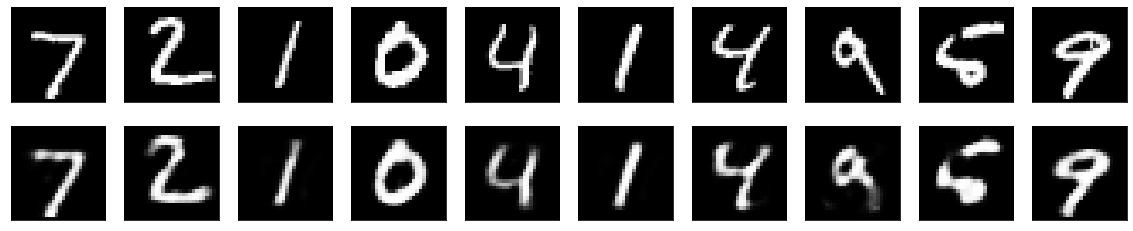

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
